In [6]:
import numpy as np      # Linear algebra.
import pandas as pd     # Data processing, CSV file I/O (e.g. pd.read_csv).
import os               # File management.
import seaborn as sns   # Drawing graphs
import matplotlib.pyplot as plt

# Input data files are available in the "../input/" directory.

print("Setup complete.")

Setup complete.


# Time Series Notebook.

This notebook aims to compute and display time series of the number of cells alive during the experiments.

## Importing dataset file names in a DataFrame to compute time series :

In [7]:
# This cell is not usefull on kaggle.com

print(os.getcwd())  
# If you're not using this notebook on kaggle.com :
# * Result should end with "/ecn_radiobiology/notebook".
# * If it is not the case, you're running the notebook on the wrong folder.

/home/momo/Documents/Centrale/EI3/PAPPL/ecn_radiobiology/notebook


In [8]:
# Path of the dataset :

path = '../input/glioblastoma-radiosensitivity-dataset/glioblastoma_data/extracted_data/cell_behaviors/videos_transcriptions_csv'
print(path)

../input/glioblastoma-radiosensitivity-dataset/glioblastoma_data/extracted_data/cell_behaviors/videos_transcriptions_csv


In [9]:
def import_files(path):
    struc = pd.DataFrame(columns =["radiation_level", "path","code_file","group"])
    read = os.walk(path)
    for root, dirs, files in read:
        for name in files:
            if name.endswith(".csv"):
                #print(name)
                radiation = name.split("gy")
                [_,group,_] = name.split("_") 
                filepath = path+ '/' + name
                code_file = name[:-4] #removing suffix
                
                struc = struc.append({"radiation_level" : int(radiation[0]), "path" : filepath, "code_file" : code_file, "group" : group}, ignore_index=True)
                
    return struc

In [10]:
# Importing the path of each file of the dataset in a DataFrame.

dataset = import_files(path)

dataset.head()

,radiation_level,path,code_file,group
0,10,../input/glioblastoma-radiosensitivity-dataset...,10gy_n3_07-06-2021-10Gy-u251-5B,n3
1,10,../input/glioblastoma-radiosensitivity-dataset...,10gy_n2_2021n210Gy6C,n2
2,2,../input/glioblastoma-radiosensitivity-dataset...,2gy_n3_2021-04-2Gy-2C,n3
3,4,../input/glioblastoma-radiosensitivity-dataset...,4gy_n1_160930.nd2u2514gyp1,n1
4,15,../input/glioblastoma-radiosensitivity-dataset...,15gy_n2_2021N215GY5B,n2


## Computing the time series of each experiment :

In [11]:
# Functions used to compute the time series :

def str_to_numpy(input_str):
    """
    str_to_numpy is used to parse the columns "input" and "output" of the dataset csv files.
    It converts a string representing an array of cells to a numpy array containing strings
    which are the names of these cells.
    """
    process_str = input_str.replace("[", "")
    process_str = process_str.replace("'", "")
    process_str = process_str.replace(" ", "")
    process_str = process_str.replace("]", "")
    if(process_str != ""):
        process_str = process_str.split(",")
        output_array = np.asarray(process_str, dtype=str)
    else:
        output_array = np.asarray([], dtype=str)
    return output_array

def biomass(row):
    """
    biomass is used on an experiment DataFrame with the .apply() method to compute
    the time series.
    Before using on a DataFrame, static variable biomass.last should be set to 0.
    """
    nb_in = row.input.size
    nb_out = row.output.size
    biomass.last = biomass.last + (nb_out - nb_in)
    row["cellAlive"] = biomass.last
    return row
biomass.last = 0

def compute_time_serie(data):
    """
    Compute the time serie of the DataFrame data using the biomass function.
    """
    biomass.last = 0
    return data[data["event"] != "end"].sort_values(by="time").apply(biomass, axis=1).groupby("time").agg({"cellAlive" : "max"}).reset_index()

def compute_time_series(row):
    """
    Compute the time series of each experiment in the DataFrame which represents the dataset.
    This function should be applied on the dataset which represents the dataset with the .apply() method.
    It then returns a DataFrame that include the time series.
    """
    file = row.path
    data = pd.read_csv(file, converters = {"input" : str_to_numpy, "output" : str_to_numpy})
    time_series = compute_time_serie(data)
    row["time"] = time_series.time.to_numpy()
    row["time_series"] = time_series.cellAlive.to_numpy()
    return row


In [12]:
# Use the previous function to compute all the time series :

time_series = dataset.apply(compute_time_series, axis=1)
time_series.head()

,radiation_level,path,code_file,group,time,time_series
0,10,../input/glioblastoma-radiosensitivity-dataset...,10gy_n3_07-06-2021-10Gy-u251-5B,n3,"[0, 100, 137, 141, 159, 167, 173, 177, 178, 19...","[24, 23, 25, 27, 28, 29, 30, 29, 30, 29, 30, 3..."
1,10,../input/glioblastoma-radiosensitivity-dataset...,10gy_n2_2021n210Gy6C,n2,"[0, 190, 207, 310, 327, 342, 446, 493, 515, 51...","[7, 8, 7, 6, 8, 7, 6, 5, 4, 2, 1]"
2,2,../input/glioblastoma-radiosensitivity-dataset...,2gy_n3_2021-04-2Gy-2C,n3,"[0, 17, 58, 72, 94, 99, 110, 115, 117, 118, 14...","[11, 10, 11, 12, 13, 14, 15, 16, 17, 16, 17, 1..."
3,4,../input/glioblastoma-radiosensitivity-dataset...,4gy_n1_160930.nd2u2514gyp1,n1,"[0, 10, 130, 151, 170, 302, 310, 324, 345, 400...","[6, 5, 6, 7, 8, 9, 10, 11, 10, 11, 10, 10, 9, ..."
4,15,../input/glioblastoma-radiosensitivity-dataset...,15gy_n2_2021N215GY5B,n2,"[0, 233, 321, 343, 361, 396, 417, 496, 504, 570]","[4, 3, 4, 3, 5, 4, 3, 2, 1, 0]"


In [13]:
# Convert the time series to a DataFrame which can be handle by seaborn

def time_series_to_seaborn(series):
    seaborn_time_series = pd.DataFrame(columns =["radiation_level", "path", "code_file", "group", "time", "biomass"])
    for i in series.index :
        row = series.iloc[i]
        for j in range(row.time.size):
            seaborn_time_series = seaborn_time_series.append(
                {"radiation_level" : row.radiation_level, "path" : row.path, 
                "code_file" : row.code_file, "group" : row.group,
                "time" : row.time[j], "biomass" : row.time_series[j]}, ignore_index=True)
    return seaborn_time_series

to_graph = time_series_to_seaborn(time_series)

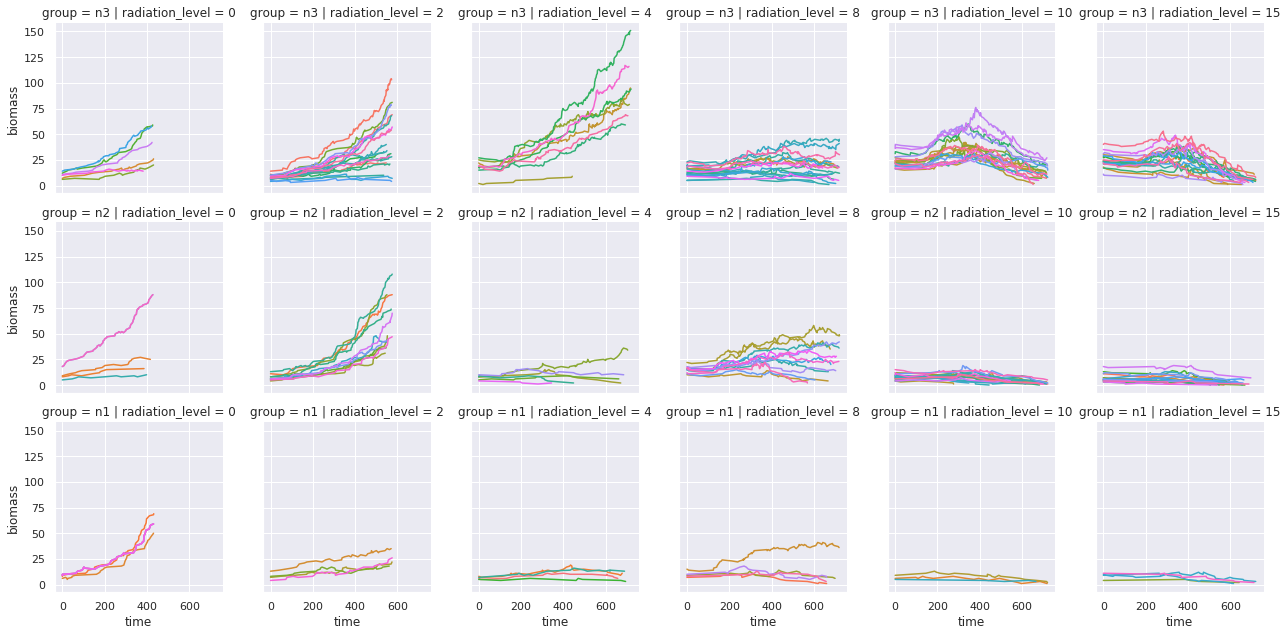

In [14]:
# Draw the time series

sns.set()
g = sns.FacetGrid(to_graph, col="radiation_level", row="group", hue="code_file")
g.map_dataframe(sns.lineplot, "time", "biomass")
